# IMPORTING PACKAGES AND DATA

In [10]:
!pip install matplotlib
!pip install seaborn 
!pip install numpy 
!pip install rdata
!pip install pyreadr
!pip install stargazer
!pip install tabulate
!pip install statsmodels



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 49.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
import os
import pickle
import rdata
import pyreadr
from stargazer.stargazer import Stargazer
from tabulate import tabulate

In [16]:
#Read in all data
data = pd.read_csv("clim_conflict_for_R.csv")
area = pd.read_csv("croparea_weight.csv", encoding="windows-1252")
ssa = pd.read_csv("gseasSSA.csv")
cltol = pd.read_csv("precip_climatology.csv", index_col=0)
mss_country = pd.read_csv("mss_countries_new.csv", header=0)
mss_country.iloc[:, 0] = mss_country.iloc[:, 0].astype(str)
mss = mss_country.iloc[:, 0].unique().tolist()
scenario_df = pd.read_csv("altogether_monthly.csv")

In [19]:
#Import the altogether_montly array
altogether_monthly = np.load("altogether_monthly.npy")

# CLARIFICATION NOTE!

We created a bootstrap generator that saves pickle files for the 9 models used in the original research paper. The generator can take extended periods of time to create the 10000 bootstraps for each model. Therefore, with the purpose of easing the run of the code, we decided to include our own bootstraps in the submission file to run this notebook, instead of including the generator. However, the generator code was included in a separate notebook ("bootstrap generator") in the .zip file to prove that it was successfully replicated.

# WEIGHTS BY REGION

In [22]:
#Make area weights by region
mask = area.iloc[:, 1] != "Cereals,Total +"
for i in area[mask].index:
    # Find the corresponding cereal row in the top 42 rows with same country
    match = area.iloc[:42]
    match_idx = match[match.iloc[:, 0] == area.iloc[i, 0]].index
    if not match_idx.empty:
        area.at[i, area.columns[4]] = area.at[match_idx[0], area.columns[4]]

#Calculate unweighted area sums by region
unweight = []
for j in range(1, 6):  
    cond = (area.iloc[:, 1] == "land area") & (area.iloc[:, 4] == j)
    total = area.loc[cond, area.columns[3]].sum()
    unweight.append(total)

#Normalize
unweight = np.array(unweight)
unweight = unweight / unweight.sum()

# PROJECTIONS OF INCOME AND REGIME CHANGE TO 2030

In [25]:
#Generate projections of income and regime change to 2030.
#Income projections
ystart = data.loc[data["year_actual"] == 1981, data.columns[9]]
yend = data.loc[data["year_actual"] == 2002, data.columns[9]]

# Annual growth rate
ygro = np.exp(np.log(yend.values / ystart.values) / 21)

# Projections to 2030: using fixed 2% and historical median
median_yend = np.median(yend.dropna())
median_ygro = np.median(ygro[~np.isnan(ygro)])

incchg = np.array([
    median_yend * (1.02) ** 27,                          # Fixed 2% growth
    median_yend * (median_ygro) ** 27                    # Historical median growth
]) - median_yend

# Polity projections
polstart = data.loc[data["year_actual"] == 1981, data.columns[227]]
polend = data.loc[data["year_actual"] == 2002, data.columns[227]]

polchg = polend.values - polstart.values
pol2030 = polend.values + np.median(polchg[~np.isnan(polchg)])
pol2030 = np.clip(pol2030, None, 10)
polchg = np.mean(pol2030 - polend.values)

# CLIMATE PROJECTIONS

In [28]:
#Climate model projections
clim = np.empty((6, 3, 2, 20))  # dims: region, model, variable (temp/precip), projection

#For temperature, averaging over monthly projected changes
k = 0
for i in range(5):       
    for j in range(3):  
        slice_ = altogether_monthly[i + 3, :, j, k, :20]  # (12 months x 20 projections)
        clim[i, j, k, :] = slice_.mean(axis=0)

#For precip, apply percentage changes to baseline climatatology, then compute total change in precip across months 
k = 1
for i in range(5):
    for j in range(3):
        for n in range(20):
            chg = altogether_monthly[i + 3, :, j, k, n] / 100 + 1
            clim[i, j, k, n] = (np.sum(cltol.iloc[i, :] * chg) / np.sum(cltol.iloc[i, :]) - 1) * 100 
for j in range(3):
    for k in range(2):
        for n in range(20):
            clim[5, j, k, n] = np.sum(clim[0:5, j, k, n] * unweight)
#Fixing an error where NaNs appear as -100 values
clim[clim == -100] = np.nan

/root/venv/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_40/1190004525.py:16: RuntimeWarning: invalid value encountered in divide
  chg = altogether_monthly[i + 3, :, j, k, n] / 100 + 1


# TABLE 1

In [31]:
#List with all the icc codes and icc years
icc_columns = [col for col in data if col.startswith("iccode")]
icc_year_columns = [col for col in data if col.startswith("Iccyear")]

In [34]:
#Sort Dataframe 
climate_conflict_table1 = data[
    ["country"]+["year_actual"]+["war_prio_new"]+["temp_all"]+["temp_all_lag"]+
    ["prec_all"]+["prec_all_lag"]+["gdp_l"]+["polity2_lag"]+["year"]+icc_columns+icc_year_columns
]


In [37]:
#Define lists for the fixed effects variables in the table 1 regressions 
icc_columns_mo = [col for col in data.columns if col.startswith("iccode")]
icc_year_columns_mo = [col for col in data.columns if col.startswith("Iccyear")]

In [40]:
X1 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+icc_columns_mo+icc_year_columns_mo + ["war_prio_new"]].dropna()
y = X1["war_prio_new"]
X1 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+icc_columns_mo+icc_year_columns_mo].dropna()
#Add constant 
X1 = sm.add_constant(X1)
#Create model 1 regression
model1 = sm.OLS(y,X1).fit()
#Summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           war_prio_new   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     18.59
Date:                Fri, 02 May 2025   Prob (F-statistic):          1.43e-137
Time:                        03:39:00   Log-Likelihood:                 246.53
No. Observations:                 889   AIC:                            -325.1
Df Residuals:                     805   BIC:                             77.32
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1099      0.730     -1.520      0.129      -2.544       0.324
temp_all         0.0447      0.022      2.077      0.038       0.002       0.087
temp_all_lag     0.0087      0.022      0.399      0.690      -0.034       0.052
iccode1         -0.3584      0.130     -2.753      0.006      -0.614      -0.103
iccode2         -0.3396      0.145     -2.347      0.019      -0.624      -0.056
iccode3         -0.4016      0.174     -2.313      0.021      -0.742      -0.061
iccode4         -0.3813      0.164     -2.331      0.020      -0.702      -0.060
iccode5         -0.3829      0.164     -2.337      0.020      -0.704      -0.061
iccode6         -0.3667      0.157     -2.341      0.019      -0.674      -0.059
iccode7         -0.3430      0.146     -2.343      0.019      -0.630      -0.056
iccode8         -0.2962      0.127     -2.338      0.020      -0.545      -0.048
iccode9         -0.2510      0.112     -2.246      0.025      -0.470      -0.032
iccode10        -0.4041      0.175     -2.305      0.021      -0.748      -0.060
iccode11        -0.1286      0.107     -1.202      0.230      -0.339       0.081
iccode12        -0.3933      0.118     -3.336      0.001      -0.625      -0.162
iccode13        -0.3604      0.154     -2.347      0.019      -0.662      -0.059
iccode14        -0.3474      0.148     -2.352      0.019      -0.637      -0.057
iccode15        -0.1957      0.099     -1.977      0.048      -0.390      -0.001
iccode16        -0.3311      0.141     -2.352      0.019      -0.607      -0.055
iccode17        -0.2126      0.102     -2.088      0.037      -0.412      -0.013
iccode18        -0.2102      0.102     -2.067      0.039      -0.410      -0.011
iccode19        -0.1325      0.134     -0.987      0.324      -0.396       0.131
iccode20        -0.2819      0.098     -2.869      0.004      -0.475      -0.089
iccode21        -0.4201      0.097     -4.348      0.000      -0.610      -0.230
iccode22         1.2460      0.099     12.604      0.000       1.052       1.440
iccode23        -0.2021      0.100     -2.014      0.044      -0.399      -0.005
iccode24        -0.0859      0.103     -0.833      0.405      -0.288       0.116
iccode25        -0.3332      0.137     -2.427      0.015      -0.603      -0.064
iccode26         0.0236      0.167      0.141      0.888      -0.305       0.352
iccode27        -0.0618      0.137     -0.451      0.652      -0.331       0.207
iccode28        -0.3584      0.154     -2.323      0.020      -0.661      -0.056
iccode29         1.2104      0.103     11.752      0.000       1.008       1.413
iccode30         1.1312      0.125      9.055      0.000       0.886       1.376
iccode31         1.3013      0.096     13.594      0.000       1.113       1.489
iccode32        -0.0510      0.112     -0.453      0.650      -0.272       0.170
iccod

In [43]:
#model 2
X2 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+["prec_all"]+["prec_all_lag"]+icc_columns_mo+icc_year_columns_mo
+ ["war_prio_new"]].dropna()
y2 = X2["war_prio_new"]
#Add constant 
X2 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+["prec_all"]+["prec_all_lag"]+icc_columns_mo+icc_year_columns_mo].dropna()
X2 = sm.add_constant(X2)
#Create model 2 regression
model2 = sm.OLS(y2,X2).fit()
#Summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           war_prio_new   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     18.12
Date:                Fri, 02 May 2025   Prob (F-statistic):          2.30e-136
Time:                        03:39:02   Log-Likelihood:                 246.70
No. Observations:                 889   AIC:                            -321.4
Df Residuals:                     803   BIC:                             90.55
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1771      0.787     -1.496      0.135      -2.722       0.367
temp_all         0.0430      0.023      1.900      0.058      -0.001       0.087
temp_all_lag     0.0132      0.023      0.566      0.572      -0.033       0.059
prec_all        -0.0230      0.059     -0.392      0.695      -0.138       0.092
prec_all_lag     0.0250      0.059      0.421      0.674      -0.092       0.141
iccode1         -0.3631      0.143     -2.538      0.011      -0.644      -0.082
iccode2         -0.3472      0.147     -2.368      0.018      -0.635      -0.059
iccode3         -0.4136      0.176     -2.353      0.019      -0.758      -0.069
iccode4         -0.3914      0.165     -2.372      0.018      -0.715      -0.068
iccode5         -0.3950      0.170     -2.331      0.020      -0.728      -0.062
iccode6         -0.3762      0.162     -2.328      0.020      -0.693      -0.059
iccode7         -0.3516      0.151     -2.326      0.020      -0.648      -0.055
iccode8         -0.3047      0.136     -2.244      0.025      -0.571      -0.038
iccode9         -0.2568      0.129     -1.989      0.047      -0.510      -0.003
iccode10        -0.4168      0.178     -2.342      0.019      -0.766      -0.068
iccode11        -0.1360      0.156     -0.873      0.383      -0.442       0.170
iccode12        -0.4034      0.180     -2.244      0.025      -0.756      -0.051
iccode13        -0.3720      0.162     -2.297      0.022      -0.690      -0.054
iccode14        -0.3583      0.155     -2.318      0.021      -0.662      -0.055
iccode15        -0.1998      0.113     -1.767      0.078      -0.422       0.022
iccode16        -0.3413      0.147     -2.329      0.020      -0.629      -0.054
iccode17        -0.2182      0.127     -1.718      0.086      -0.468       0.031
iccode18        -0.2143      0.110     -1.953      0.051      -0.430       0.001
iccode19        -0.1403      0.137     -1.021      0.307      -0.410       0.129
iccode20        -0.2863      0.116     -2.473      0.014      -0.513      -0.059
iccode21        -0.4235      0.109     -3.897      0.000      -0.637      -0.210
iccode22         1.2479      0.101     12.372      0.000       1.050       1.446
iccode23        -0.2041      0.101     -2.012      0.045      -0.403      -0.005
iccode24        -0.0836      0.103     -0.810      0.418      -0.286       0.119
iccode25        -0.3259      0.138     -2.361      0.018      -0.597      -0.055
iccode26         0.0346      0.169      0.204      0.838      -0.298       0.367
iccode27        -0.0693      0.140     -0.493      0.622      -0.345       0.206
iccode28        -0.3676      0.157     -2.343      0.019      -0.676      -0.060
iccode29         1.2139      0.106     11.471      0.000       1.006       1.422
iccode30         1.1372      0.127      8.940      0.000       0.888       1.387
iccod

In [46]:
X3 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+["prec_all"]+["prec_all_lag"]+["gdp_l"]+["polity2_lag"]+["year"]+
icc_columns_mo + ["war_prio_new"]].dropna()
y3 = X3["war_prio_new"]
X3 = climate_conflict_table1[["temp_all"]+["temp_all_lag"]+["prec_all"]+["prec_all_lag"]+["gdp_l"]+["polity2_lag"]+["year"]+
icc_columns_mo].dropna()
#Add constant 
X3 = sm.add_constant(X3)
#Create model 3 regression
model3 = sm.OLS(y3,X3).fit()
#Summary
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           war_prio_new   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     11.12
Date:                Fri, 02 May 2025   Prob (F-statistic):           9.81e-57
Time:                        03:39:06   Log-Likelihood:                 27.536
No. Observations:                 815   AIC:                             34.93
Df Residuals:                     770   BIC:                             246.6
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5215      0.983     -1.547      0.122      -3.452       0.409
temp_all         0.0489      0.029      1.698      0.090      -0.008       0.106
temp_all_lag     0.0206      0.030      0.694      0.488      -0.038       0.079
prec_all         0.0165      0.075      0.221      0.825      -0.130       0.163
prec_all_lag     0.0278      0.074      0.377      0.706      -0.117       0.173
gdp_l        -2.663e-05   2.11e-05     -1.260      0.208   -6.81e-05    1.49e-05
polity2_lag     -0.0005      0.002     -0.234      0.815      -0.005       0.004
year            -0.0041      0.002     -2.169      0.030      -0.008      -0.000
iccode1         -0.3077      0.150     -2.051      0.041      -0.602      -0.013
iccode2         -0.3575      0.152     -2.358      0.019      -0.655      -0.060
iccode3         -0.4088      0.189     -2.159      0.031      -0.780      -0.037
iccode4         -0.3766      0.172     -2.185      0.029      -0.715      -0.038
iccode5         -0.3663      0.155     -2.363      0.018      -0.671      -0.062
iccode6         -0.3508      0.172     -2.041      0.042      -0.688      -0.013
iccode7         -0.3170      0.151     -2.105      0.036      -0.613      -0.021
iccode8         -0.2611      0.119     -2.196      0.028      -0.494      -0.028
iccode9         -0.2285      0.113     -2.031      0.043      -0.449      -0.008
iccode10        -0.4153      0.179     -2.327      0.020      -0.766      -0.065
iccode11        -0.1043      0.164     -0.638      0.524      -0.425       0.217
iccode12        -0.2335      0.181     -1.294      0.196      -0.588       0.121
iccode13        -0.3536      0.150     -2.351      0.019      -0.649      -0.058
iccode14        -0.3334      0.135     -2.478      0.013      -0.598      -0.069
iccode15        -0.1493      0.090     -1.665      0.096      -0.325       0.027
iccode16        -0.3248      0.131     -2.478      0.013      -0.582      -0.067
iccode17        -0.0133      0.192     -0.069      0.945      -0.391       0.364
iccode18        -0.1954      0.077     -2.550      0.011      -0.346      -0.045
iccode19        -0.2068      0.132     -1.568      0.117      -0.466       0.052
iccode20        -0.0711      0.090     -0.789      0.430      -0.248       0.106
iccode21         0.0168      0.077      0.217      0.828      -0.135       0.169
iccode22         0.3942      0.069      5.737      0.000       0.259       0.529
iccode23        -0.1473      0.064     -2.299      0.022      -0.273      -0.022
iccode24        -0.0312      0.084     -0.373      0.709      -0.195       0.133
iccode25         0.2874      0.147      1.952      0.051      -0.002       0.576
iccode26         0.3859      0.195      1.977      0.048       0.003       0.769
iccode27        -0.1077      0.131     -0.822      0.411      -0.365       0.150
iccod

In [49]:
#Setting up table with coefficients of the three models
stargazer = Stargazer([model1, model2, model3])
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(4)
stargazer.covariate_order(["temp_all", "temp_all_lag", "prec_all", "prec_all_lag", "gdp_l", "polity2_lag", "const"])
stargazer.title("Table 1. Regression coefficients on climate variables, with civil war as a dependent variable")

stargazer

# FIGURE 1

In [52]:
# - Figure 1 Panel 1
# - Boxplots for projected precipitation change (%) on top row
# - Boxplots for projected temperature change (°C) on bottom row
# - For 5 SSA regions + SSA-wide (6 total)

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey='row')
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']

# Top row: Precipitation Change (%)
for i, region in enumerate(regions):
    precip_clean = clim[i, 1, 1, :]
    precip_clean = precip_clean[~np.isnan(precip_clean)]
    axes[0, i].boxplot(precip_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3), 
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[0, i].set_title(region, fontsize=10)
    axes[0, i].set_ylim([-5, 15])
    if i == 0:
        axes[0, i].set_ylabel("Precipitation Change (%)")

# Bottom row: Temperature Change (°C)
for i, region in enumerate(regions):
    temp_clean = clim[i, 1, 0, :]
    temp_clean = temp_clean[~np.isnan(temp_clean)]
    axes[1, i].boxplot(temp_clean, 
                       patch_artist=True, 
                       boxprops=dict(facecolor=colors[i]), 
                       showfliers=False, 
                       medianprops=dict(color="black", linewidth=3),
                       whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))
    axes[1, i].set_ylim([0, 2])
    if i == 0:
        axes[1, i].set_ylabel("Temperature Change (°C)")

plt.suptitle("Figure 1 (Left): Projected Changes in Climate to 2030", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [55]:
#Figure 1 Panel 2

#Visualization of one of the generated bootstraps
coefs_model_1 = pd.read_pickle('bootstrap_df_1.pkl')
coefs_model_1

# Simulated OLS estimates for temp_all and temp_all_lag from Model 1
coefs_mean = np.array([coefs_model_1["temp_all"].mean(), coefs_model_1["temp_all_lag"].mean()])

#Coefs bootstrapped
coefs_boot = coefs_model_1[["temp_all", "temp_all_lag"]].to_numpy()

In [58]:
# Simulated temp projections per region (6 regions x 20 models)
temp_proj_models = clim[:, 1, 0, :]

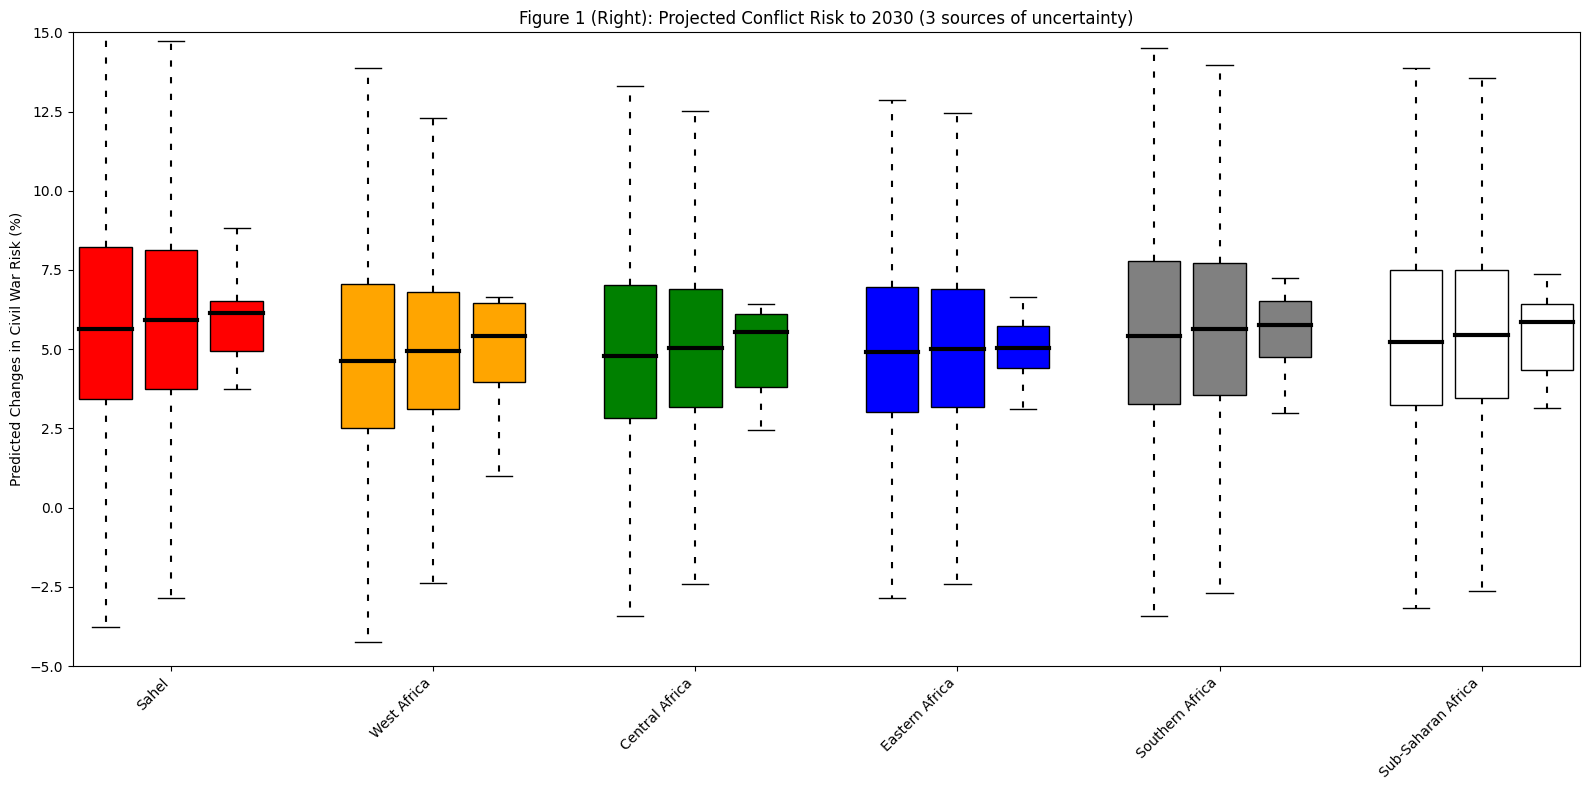

In [61]:
# Simulate all 3 boxplot scenarios
regions = ["Sahel", "West Africa", "Central Africa", "Eastern Africa", "Southern Africa", "Sub-Saharan Africa"]
colors = ['red', 'orange', 'green', 'blue', 'grey', 'white']
n_bootstrap = 10000

# Storage: per region
conflict_preds_full = []   # Full uncertainty
conflict_preds_conflict_only = []  # Conflict model uncertainty only
conflict_preds_climate_only = []   # Climate model uncertainty only

# For each region
for i in range(6):
    temp_proj = temp_proj_models[i, :]
    temp_proj = temp_proj[~np.isnan(temp_proj)]  # Clean NaN if any
    
    # Boxplot 1: Full uncertainty (sample both coefs and temps)
    preds_full = []
    for _ in range(n_bootstrap):
        coef = coefs_boot[np.random.choice(range(n_bootstrap))]
        temp = np.random.choice(temp_proj)
        pred = 100 * (coef[0] * temp + coef[1] * temp)
        preds_full.append(pred)
    conflict_preds_full.append(preds_full)
    
    # Boxplot 2: Conflict model uncertainty only (fixed temp)
    temp_mean = np.mean(temp_proj)
    preds_conflict = []
    for coef in coefs_boot:
        pred = 100 * (coef[0] * temp_mean + coef[1] * temp_mean)
        preds_conflict.append(pred)
    conflict_preds_conflict_only.append(preds_conflict)
    
    # Boxplot 3: Climate model uncertainty only (fixed coefs)
    preds_climate = []
    for temp in temp_proj:
        pred = 100 * (coefs_mean[0] * temp + coefs_mean[1] * temp)
        preds_climate.append(pred)
    preds_climate = np.random.choice(preds_climate, size=n_bootstrap, replace=True)
    conflict_preds_climate_only.append(preds_climate)

# Plot all 3 boxplots per region
fig, ax = plt.subplots(figsize=(16, 8))

positions = []
labels = []
data1 = []

# Collect data for grouped plotting
for i, region in enumerate(regions):
    base = i * 4
    positions.extend([base, base+1, base+2])
    labels.extend([region + " (full)", region + " (conflict)", region + " (climate)"])
    data1.extend([
        conflict_preds_full[i],
        conflict_preds_conflict_only[i],
        conflict_preds_climate_only[i]
    ])

# Make boxplots
box = ax.boxplot(data1, 
                 positions=positions, 
                 widths=0.8, 
                 patch_artist=True, 
                 showfliers= False, 
                 medianprops=dict(color="black", linewidth=3),
                 whiskerprops=dict(linestyle=(0, (3, 5)), color="black", linewidth=1.5))

# Color coding
for patch, color_idx in zip(box['boxes'], np.repeat(range(6), 3)):
    patch.set_facecolor(colors[color_idx])

ax.set_ylim(-5, 15)

ax.set_xticks([i * 4 + 1 for i in range(6)])
ax.set_xticklabels(regions, rotation=45, ha="right")
ax.set_ylabel("Predicted Changes in Civil War Risk (%)")
ax.set_title("Figure 1 (Right): Projected Conflict Risk to 2030 (3 sources of uncertainty)")

plt.tight_layout()
plt.show()

# TABLE 2

In [64]:
bootstrap_ids = [1, 2, 4, 4]
hold = [pd.read_pickle(f"bootstrap_df_{i}.pkl") for i in bootstrap_ids]

#Initialize projection matrix
projections = pd.DataFrame(index=[
    "A1btemp", "A1btemp_prec", "A2temp", "A2temp_prec", "B1temp", "B1temp_prec"
], columns=["median", "med_inc", "5th_inc", "95th_inc", "% obs<0"])

# Baseline civil war incidence
base = data.loc[data["year_actual"] < 2003, "war_prio_new"].mean()

# Mapping positions
where = np.array([[0, 2, 4], [1, 3, 5]])

# Iterate over models and climate scenarios
for i in range(2):  # i=0 (model 1), i=1 (model 2)
    coef = hold[i].copy()
    k = 5  # AllSSA_unweight index

    for x in range(3):  # 3 climate scenarios
        proj_t = clim[k, x, 0, :]
        proj_p = clim[k, x, 1, :] * data.iloc[:, 53].dropna().mean() / 100

        proj_t = proj_t[~np.isnan(proj_t)]
        proj_p = proj_p[~np.isnan(proj_p)]

        # Zero-out unwanted coefficients
        if i == 0:
            coef.iloc[:, 2:6] = 0
        elif i == 1:
            coef.iloc[:, 4:6] = 0

        # Generate predictions
        all_preds = []
        for j in range(len(proj_t)):
            preds = (
                proj_t[j] * (coef.iloc[:, 0] + coef.iloc[:, 1]) +
                proj_p[j] * (coef.iloc[:, 2] + coef.iloc[:, 3])
            )
            all_preds.extend(preds)

        all_preds = np.sort(np.array(all_preds)) * 100
        n = len(all_preds)
        all95 = all_preds[int(n * 0.025):int(n * 0.975)]

        # Store stats
        idx = where[i, x]
        projections.iloc[idx] = [
            np.median(all95),
            np.median(all95) / base,
            np.min(all95) / base,
            np.max(all95) / base,
            np.mean(all_preds < 0) * 100
        ]
projections

median    med_inc   5th_inc    95th_inc   % obs<0
A1btemp       5.927261  53.768722 -3.923425  133.429194      3.41
A1btemp_prec  6.241885  56.622816 -6.678321  145.334644  3.883333
A2temp        5.227701   47.42272 -3.446792  113.173533      3.41
A2temp_prec   5.507287  49.958962  -6.03482  123.253086  3.917333
B1temp        4.786618  43.421467 -3.171171  112.423845      3.41
B1temp_prec   5.057733  45.880863 -5.661032    122.1352  3.967778

In [67]:
#Buiding organized dataframe
scenarios = ["A1B", "A1B", "A2", "A2", "B1", "B1"]
models = ["Model 1", "Model 2"] * 3

formatted = pd.DataFrame({
    "Scenario": scenarios,
    "Model": models,
    "Median % change": projections["median"].astype(float).round(1),
    "% increase vs baseline": projections["med_inc"].astype(float).round(1),
    "5th–95th percentile": [
        f"{projections.iloc[i]['5th_inc']:.1f}–{projections.iloc[i]['95th_inc']:.1f}"
        for i in range(len(projections))
    ],
    "% obs < 0": projections["% obs<0"].astype(float).round(1)
})

print(tabulate(formatted, headers='keys', tablefmt='fancy_grid'))

╒══════════════╤════════════╤═════════╤═══════════════════╤══════════════════════════╤═══════════════════════╤═════════════╕
│              │ Scenario   │ Model   │   Median % change │   % increase vs baseline │ 5th–95th percentile   │   % obs < 0 │
╞══════════════╪════════════╪═════════╪═══════════════════╪══════════════════════════╪═══════════════════════╪═════════════╡
│ A1btemp      │ A1B        │ Model 1 │               5.9 │                     53.8 │ -3.9–133.4            │         3.4 │
├──────────────┼────────────┼─────────┼───────────────────┼──────────────────────────┼───────────────────────┼─────────────┤
│ A1btemp_prec │ A1B        │ Model 2 │               6.2 │                     56.6 │ -6.7–145.3            │         3.9 │
├──────────────┼────────────┼─────────┼───────────────────┼──────────────────────────┼───────────────────────┼─────────────┤
│ A2temp       │ A2         │ Model 1 │               5.2 │                     47.4 │ -3.4–113.2            │         3.4 │


# FIGURE 2

Processing model 1 with shape (10000, 6)
Processing model 2 with shape (10000, 6)
Processing model 3 with shape (10000, 6)
Processing model 4 with shape (10000, 6)
Processing model 5 with shape (10000, 6)
Processing model 6 with shape (10000, 6)
Processing model 7 with shape (10000, 6)
Processing model 8 with shape (10000, 6)
/tmp/ipykernel_40/3476913435.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


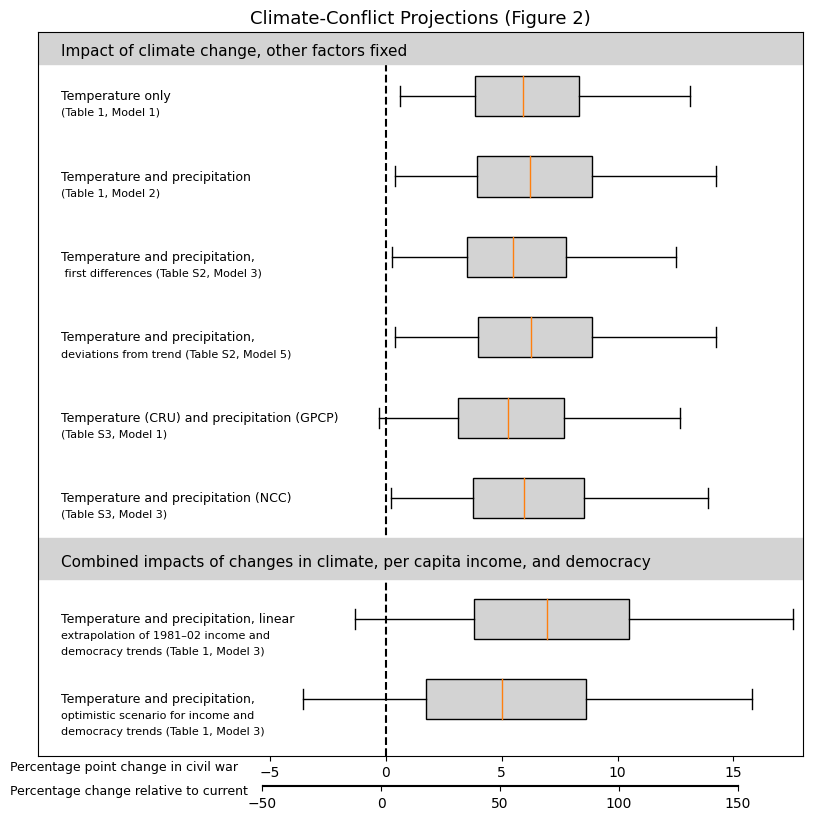

In [70]:
#Creating list containing bootstraps pickle files
bootstrap_ids = [1, 2, 6, 7, 8, 9, 4, 4]
hold = [pd.read_pickle(f"bootstrap_df_{i}.pkl") for i in bootstrap_ids]
#Labels for figure
nms = [
    "Temperature only", "Temperature and precipitation", "Temperature and precipitation,",
    "Temperature and precipitation,", "Temperature (CRU) and precipitation (GPCP)",
    "Temperature and precipitation (NCC)", "Temperature and precipitation, linear",
    "Temperature and precipitation,"
]
nms2 = [
    "(Table 1, Model 1)", "(Table 1, Model 2)", " first differences (Table S2, Model 3)",
    "deviations from trend (Table S2, Model 5)", "(Table S3, Model 1)",
    "(Table S3, Model 3)", "extrapolation of 1981–02 income and", "optimistic scenario for income and"
]
nms3 = [""] * 6 + ["democracy trends (Table 1, Model 3)"] * 2

#Projection inputs
k = 5  
mean_precip = data["prec_seas_maize"].mean()
proj_t = clim[k, 0, 0, :]  
proj_t = proj_t[~np.isnan(proj_t)] 
proj_p = clim[k, 0, 1, :] * mean_precip / 100  
proj_p = proj_p[~np.isnan(proj_p)]

#Plot setup
fig, ax = plt.subplots(figsize=(8, 8))
positions = np.array([8.2, 7.2, 6.2, 5.2, 4.2, 3.2, 1.7, 0.7])
#positions = np.arange(len(hold), 0, -1) - 0.1
#positions[positions < 2.5] -= 0.7  # offset bottom plots

for i, coef in enumerate(hold):
    print(f"Processing model {i+1} with shape {coef.shape}")
    coef = coef.copy()

    if i == 0:
        coef.iloc[:, 2:6] = 0  # zero precip and policy vars
    if i in range(1, 6):
        coef.iloc[:, 4:6] = 0  # zero income and polity vars

    # Handle income projections
    inc = 0
    if i == 6:
        inc = incchg[1]
    elif i == 7:
        inc = incchg[0]

    #Predict civil war change
    all_preds = []
    for j in range(len(proj_t)):
        #try:
            pred = (
                proj_t[j] * (coef.iloc[:, 0] + coef.iloc[:, 1]) +
                proj_p[j] * (coef.iloc[:, 2] + coef.iloc[:, 3]) +
                inc * coef.iloc[:, 4] +
                polchg * coef.iloc[:, 5]
            )
            all_preds.append(pred.values)

    if not all_preds:
        print(f"Skipping model {i+1}: no valid projections")
        continue

    all_preds = np.concatenate(all_preds)
    all_preds = np.sort(all_preds) * 100
   

    #Take 5th–95th percentile
    n = len(all_preds)
    all95 = all_preds[int(n * 0.05):int(n * 0.95)]

    #Boxplot
    ax.boxplot(all95, positions=[positions[i]], vert=False, widths=0.5,
               patch_artist=True, boxprops=dict(facecolor='lightgrey'))

    #Labels
    ax.text(-14, positions[i], nms[i], fontsize=9, ha='left', va='center')
    ax.text(-14, positions[i] - 0.2, nms2[i], fontsize=8, ha='left', va='center')
    ax.text(-14, positions[i] - 0.4, nms3[i], fontsize=8, ha='left', va='center')

#Final figure styling
ax.axvline(0, linestyle='dashed', color='black', zorder=0)
ax.set_xlim([-15, 18])
ax.set_ylim(0, 9)
ax.set_yticks([])
fig.text(-0.01, 0.03, "Percentage point change in civil war", ha='left', fontsize=9)
ax.set_xticks(np.arange(-5, 16, 5))
ax.set_title("Climate-Conflict Projections (Figure 2)", fontsize=13)

#Background highlight boxes
ax.add_patch(plt.Rectangle((-30, len(hold) + 0.6), 50, 1, color="lightgrey", zorder=2))
ax.text(-14, len(hold) + 0.7, "Impact of climate change, other factors fixed", fontsize=11, zorder=6)

ax.add_patch(plt.Rectangle((-30, 2.2), 50, 0.5, color="lightgrey", zorder=2))
ax.text(-14, 2.35, "Combined impacts of changes in climate, per capita income, and democracy", fontsize=11, zorder=6)

#Add a second x-axis below the original
box = ax.get_position()
ax2 = ax.figure.add_axes([box.x0 + 0.18, box.y0 - 0.1, box.width - 0.18, 0.001])  # tiny height
ax2.set_xlim(-50, 150)
ax2.set_xticks(np.arange(-50, 151, 50))
fig.text(-0.01, 0, "Percentage change relative to current", ha='left', fontsize=9)
ax2.xaxis.set_label_coords(0.33, -3)  
ax2.tick_params(axis='x', labelsize=10)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=60f244f3-405a-4901-9b63-587bfc531cf2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>